## "Active Sciencing" with Reusable Workflows

By Kyle Cranmer & Lukas Heinrich June 4, 2016

Based on earlier work with NYU CDS masters students Manoj Kumar, Phil Yeres, and Michele Ceru and discussions with Brenden Lake and Gilles Louppe.

Define:

 1) $\phi$ : Experimental configuration

 2) $\theta$: Parameters that we would like to infer from the experimental data

 3) $X$ : Data generated from the experiment or simulator



In [24]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
from scipy.stats import norm

## Step 1: Perform Experiment, Collect Data

In [4]:
def simulator(theta, phi, n_samples=100):
    return np.random.normal(loc=theta, scale=2 + np.sin(phi), size=n_samples)

def collect_data(phi, n_samples=100):
    # 3.141 is the unknown parameter we are trying to measure
    # best experimental setting is 3pi/2 (or any multiple of it)
    return simulator(3.141, phi, n_samples)

data = np.random.normal(3.14, 1, size=100)

## Step 2: Bayesian Prior → Posterior Update 

In [34]:
def lnprior(theta, prior):
    # XXX incorporate the prior passed in here
    if 0. < theta < 2*np.pi:
        return 0.
    return -np.inf

def lnlike(theta, y, phi):
    mean, std = theta, phi
    return np.log(norm(mean, std).pdf(y).prod())

def lnprob(theta, x, prior, phi):
    lp = lnprior(theta, prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

def calculate_posterior(prior, data, phi):
    """Compute samples from the posterior"""
    ndim, n_walkers = 1, 10
    pos = [2. + 1e-1*np.random.randn(ndim) for i in range(n_walkers)]
    
    sampler = emcee.EnsembleSampler(n_walkers, 1, lnprob, args=(data, prior, phi))
    pos, prob, state = sampler.run_mcmc(pos, 100)
    
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 300)
    
    return Distribution(prior.name, prior.range, sampler.flatchain)

In [35]:
posterior = calculate_posterior(Distribution('mean', range=(0,2*np.pi)), data, 2)

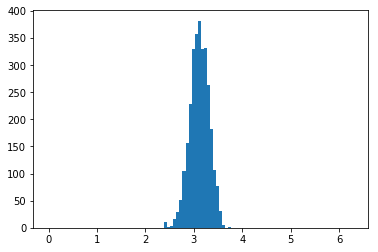

In [36]:
posterior.hist()

## Step 3: Optimize Experimental Configuration

Based on the updated posterior $p(\theta)$ we will consider future experiments with configuration $\phi$. For each of those configurations, we will run several simulations of the experiment and perform inference on those simulated datasets to estimate the expected information gain (EIG)

\begin{equation}
EIG(\phi) =  \int dx d\theta \; p(x | \theta) p(\theta) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ] \approx \int dx  \; p(x | \theta_{MAP}) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ]
\end{equation}
where
\begin{equation}
H\left [P(\theta) \right] = \int P(\theta) \log P(\theta) d\theta 
\end{equation}

To efficiently optimize $EIG[\phi]$ we will use an active learning procedure like Bayesian Optimization.

In [ ]:
def expected_information_gain(phi, prior):
    'calculate the expression above using workflow for simulations'
    n_simulations = 10
    
    #need to pass in prior through some extra arguments
    
    # use saddle-point approximation
    theta_map = prior.map()
    
    eig = np.zeros(n_simulations)
    
    for i_sim in range(n_simulations):
        # external workflow provides simulated data
        sim_data = collect_data(phi, theta_map)

        #external workflow uses simulator to provide likelihood 
        sim_posterior = calculate_posterior(prior, sim_data, phi)
        eig[i_sim] = info_gain(prior, sim_posterior)
        
    #check for outliers?
    
    return np.mean(eig)

In [ ]:
#use scikit-optimize to optimize phi
from skopt import gp_minimize
from skopt.plots import plot_evaluations

def design_next_experiment(prior):
    bounds = [(-5.0, 10.0), (0.0, 15.0)]
    n_calls = 50

    opt_result = gp_minimize(expected_information_gain, bounds, n_calls=n_calls, random_state=4)

    _ = plot_evaluations(opt_result, bins=10)
    return opt_phi

## Run the loop

### Initialize

In [ ]:
phi = 0.
prior_theta = Distribution() #simple class for range, density for emcee via KDE or histogram, MAP?

n_science_iterations = 10

phi_history = []
prior_history = []

for i_experiment in range(science_iterations):
    phi_history.append(phi)
    prior_history.append(prior)

    # run experiment with configuration given by phi
    real_data = collect_data(phi)

    #update new prior = posterior from previous experiment
    prior = calculate_posterior(prior, real_data, phi)
    
    #design new experiment given current knowledge
    phi=design_next_experiment(prior)
    

#make some plots of prior, and phi 

In [28]:
#put this in a separate file
class Distribution:
    '''
    member vars
        variable names
        ranges  (for use with george)
    methods
        density estimate (KDE or histogram) (for use with emcee)
        MAP (for saddle point approximation)
        
    '''
    def __init__(self, name, range, samples=None):
        self.range = range
        self.name = name
        if samples is None:
            self.samples = np.random.uniform(range[0], range[1], size=10000)
        else:
            self.samples = samples
        
    def map(self):
        prob, edges = np.histogram(self.samples, range=self.range, bins=100)
        prob = prob.clip(min=0.0000000001)
        return edges[np.argmax(prob)]
    
    def hist(self):
        plt.hist(self.samples, range=self.range, bins=100)
        plt.show()